# 0. IMPORTS

## 0.0. Imports

In [1]:
import inflection
import math
import datetime
import random
import pickle

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb


from scipy                        import stats as ss
from boruta                       import BorutaPy
from IPython.core.display         import HTML
from IPython.display              import Image
from matplotlib.gridspec          import GridSpec
from sklearn.ensemble             import RandomForestRegressor
from sklearn.linear_model         import LinearRegression, Lasso
from sklearn.preprocessing        import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics              import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## 0.1. Helper Functions

In [130]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [2]:
def cross_validation(kfold, model_name, model, verbose=False):
    mae_list=[]
    mape_list=[]
    rmse_list=[]
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKfold Number: {}'.format(k))
        
        #start and end validation day
        val_start = x_training['date'].max()-datetime.timedelta(days=7*6*k)
        val_end = x_training['date'].max()-datetime.timedelta(days=7*6*(k-1))

        #filtering dataset
        training = x_training[x_training['date']<val_start]
        validation = x_training[(x_training['date']>=val_start) & (x_training['date']<=val_end)]

        #training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model training
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat=m.predict(xvalidation)

        #performace
        model_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store erformae of each kfold iteration
        mae_list.append(model_result['MAE'][0])
        mape_list.append(model_result['MAPE'][0])
        rmse_list.append(model_result['RMSE'][0])
        
    return pd.DataFrame({'Model Name': model_name,
    'MAE CV': "{:.2f} +/- {:.2f}".format(np.mean(mae_list), np.std(mae_list)),
    'MAPE CV':"{:.2f} +/- {:.2f}".format(np.mean(mape_list), np.std(mape_list)),
    'RMSE CV':"{:.2f} +/- {:.2f}".format(np.mean(rmse_list), np.std(rmse_list))}, index=[0])
    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corr=max(0, (chi2-((k-1)*(r-1)/(n-1))))

    k_corr= (k-((k-1)**2)/(n-1))
    r_corr =(r-((r-1)**2)/(n-1))

    return np.sqrt((chi2_corr/n)/min(k_corr-1, r_corr-1))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame ({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse}, index=[0])

## 0.2. Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

In [4]:
#merge:
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on= 'Store')
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
786353,1064,6,2013-07-27,6657,762,1,0,0,0,a,c,420.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0. DESCRIÇÃO DE DADOS

## 1.1. Rename Columns

In [5]:
df1 = df_raw.copy()

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimension

In [7]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Collumns: {}".format(df1.shape[1]))

Number of Rows: 1017209
Number of Collumns: 18


## 1.3. Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
              
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [12]:
#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'May', 5: 'Apr', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in str(x['promo_interval']).split(',') else 0, axis =1)

In [13]:
df1.sample(5).T

,299406,554897,946424,5471,377116
store,454,413,575,1012,581
day_of_week,6,3,2,1,7
date,2014-10-25 00:00:00,2014-02-19 00:00:00,2013-03-05 00:00:00,2015-07-27 00:00:00,2014-08-03 00:00:00
sales,2055,6893,7993,7646,0
customers,255,887,684,582,0
open,1,1,1,1,0
promo,0,1,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,d,a


## 1.6 Change types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical 

In [17]:
num_attributes = df1.select_dtypes (include=['int64', 'float64'])
cat_attributes = df1.select_dtypes (exclude= ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [18]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max,range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns=['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


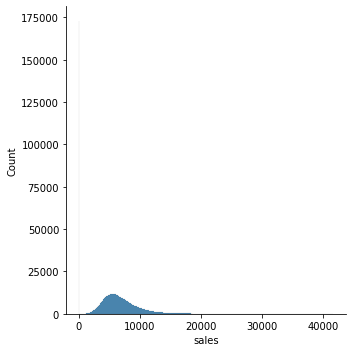

In [19]:
sns.displot(df1['sales'])

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

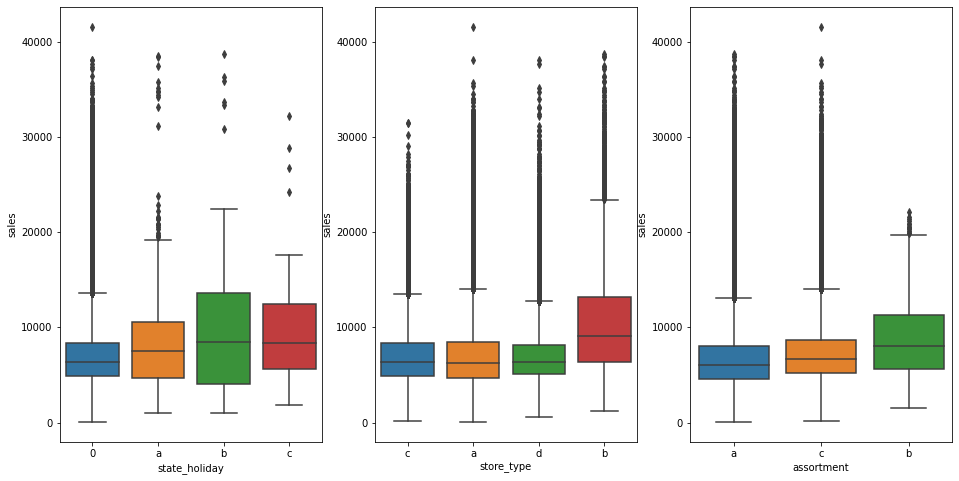

In [21]:
plt.figure(figsize=(16,8))
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. FEATURE ENGINEERING

## 2.1. Mapa mental de Hipóteses

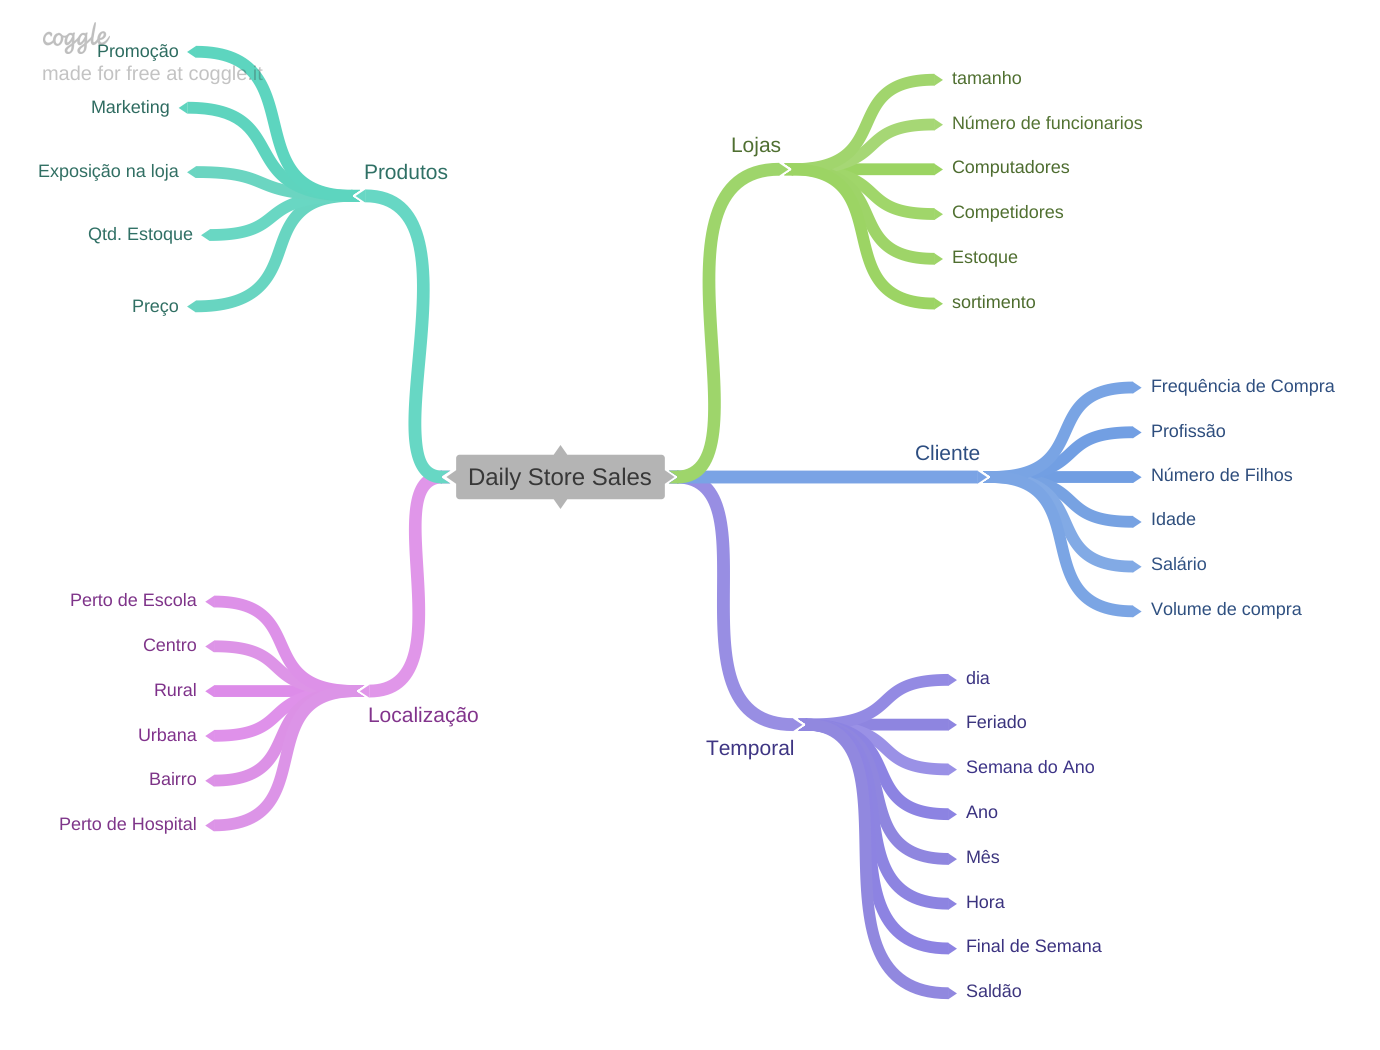

In [22]:
Image('img/Daily_Store_Sales.png')

## 2.2 Criação de Hipóteses

In [23]:
df2 = df1.copy()

### 2.2.1. Hipóteses da Loja

<ol>
    <li>Lojas com número maior de funcionários deveriam vender mais; </li>
    <li>Lojas com maior capacidade de estoque deveriam vender mais; </li>
    <li>Lojas de maior porte deveriam vender mais; </li>
    <li>Lojas com maior diversidade de produtos deveriam vender mais; </li>
    <li>Lojas com competidores mais próximos deveriam vender menos; </li>
    <li>Lojas com competidores de longa data deveriam vender mais; </li>
</ol>


### 2.2.2. Hipóteses do Produto

<ol>
    <li>Lojas que investem mais em marketng deveriam  vender mais;</li>
    <li>Lojas com maior exposição de produtos deveriam vender mais; </li>
    <li>Lojas com produtos de preços menores deveriam vender mais; </li>
    <li>Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais; </li>
    <li>Lojas com mais dias de promoção deveriam vender mais; </li>
    <li>Lojas com mais promoções consecutivas deveriam vender mais </li>
</ol>

### 2.2.3. Hipóteses Temporais

<ol>
    <li>Lojas abertas durante o feriado de natal deveriam vender mais</li>
    <li>Lojas deveriam vender mais ao longo dos anos; </li>
    <li>Lojas deveriam vender mais no segundo semestre do ano </li>
    <li>Lojas deveriam vender mais depois do dia 10 de cada mês </li>
    <li>Lojas deveriam vender menos aos finais de semana </li>
    <li>Lojas deveriam vender menos durante os feriados escolares </li>
</ol>

## 2.3. Lista Final de Hipóteses

<ol>
    <li>Lojas com maior diversidade de produtos deveriam vender mais; </li>
    <li>Lojas com competidores mais próximos deveriam vender menos; </li>
    <li>Lojas com competidores de longa data deveriam vender mais; </li>
    <li>Lojas com produtos de preços menores deveriam vender mais; </li>
    <li>Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais; </li>
    <li>Lojas com mais dias de promoção deveriam vender mais; </li>
    <li>Lojas com mais promoções consecutivas deveriam vender mais </li>
    <li>Lojas abertas durante o feriado de natal deveriam vender mais</li>
    <li>Lojas deveriam vender mais ao longo dos anos; </li>
    <li>Lojas deveriam vender mais no segundo semestre do ano </li>
    <li>Lojas deveriam vender mais depois do dia 10 de cada mês </li>
    <li>Lojas deveriam vender menos aos finais de semana </li>
    <li>Lojas deveriam vender menos durante os feriados escolares </li>
</ol>

## 2.4. Feature Engineering

In [146]:
#year
df2['year']= df2['date'].dt.year
#month
df2['month']= df2['date'].dt.month
#day
df2['day']= df2['date'].dt.day
#week of year
df2['week_of_year']= df2['date'].dt.isocalendar().week
df2['week_of_year']= df2['week_of_year'].astype('int64')
#year week
df2['year_week']= df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

KeyboardInterrupt: 

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [147]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0. FILTRAING FEATURES

In [27]:
df3 = df2.copy()

### 3.1. Filtragem de linhas

Nessa setor eu vou colocar todas as variáveis que restrigem o negócio:
A exemplo: a variável 'open' será só 0 ou 1, 0 no caso de a loja estar fechada.
A segunda variável é a de 'sales' em que 0 significa: não houve venda.

In [28]:
df3 =df3[(df3['open'] !=0) & df3['sales']>0]

### 3.2. Seleção de Colunas

Nessa seleção de colunas eu posso retirar as que não vão mais gerar novas ideias ou insights de negócios. Sendo pq as ideias principais já foram retiradas dos dados contidos nela ou por que não são mais necessários

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis =1)

In [30]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
5,6,5,2015-07-31,5651,1,regular_day,1,a,basic,310.0,...,0,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0
8,9,5,2015-07-31,8565,1,regular_day,1,a,extended,2030.0,...,0,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27,0
9,10,5,2015-07-31,7185,1,regular_day,1,a,basic,3160.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


# 4.0. EXPLORATORY DATA ANALYSIS

In [31]:
df4=df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

Aqui eu estou olhando o comportamento da variável de resposta, porque, geralmente os algoratmos de machine larne utilizama  adistribuição de poason (distribuição normal) para fazer as correlações.

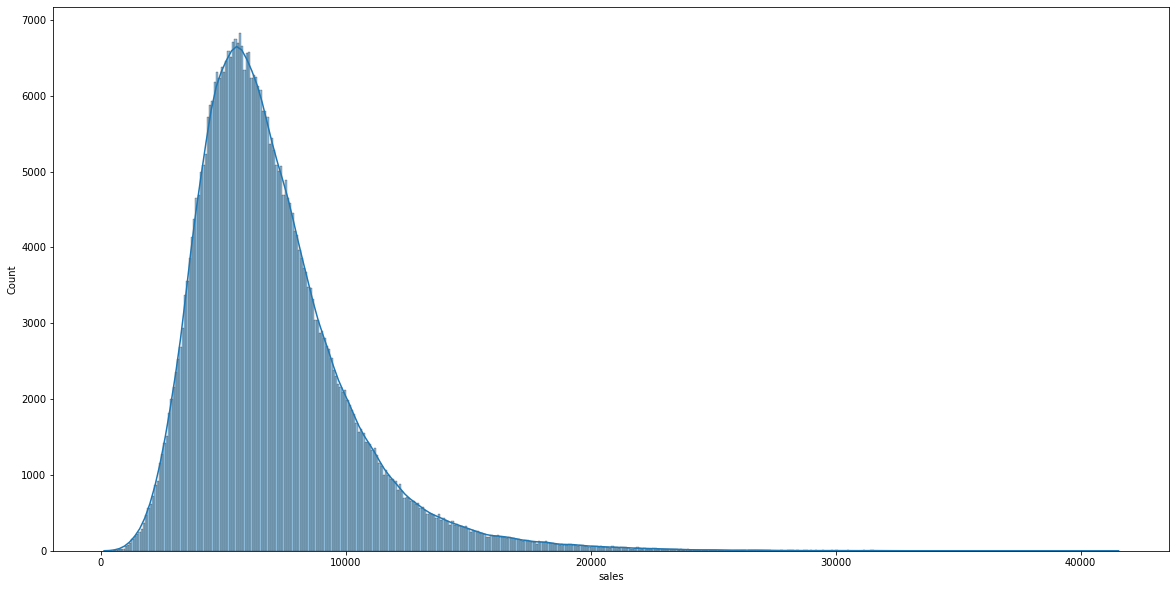

In [32]:
plt.figure(figsize=(20, 10))
sns.histplot(df4['sales'], kde=True);

### 4.1.2. Numerical Variable

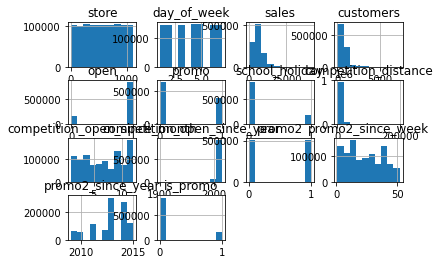

In [33]:
num_attributes.hist();

### 4.1.3. Categorical Variable

Aqui é para tendar entender se vale a pena levar essas variáveis para o modelo, vendo se as variáveis têm informações relevantes para o modelo.

In [34]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [35]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
273       extra
Name: assortment, dtype: object

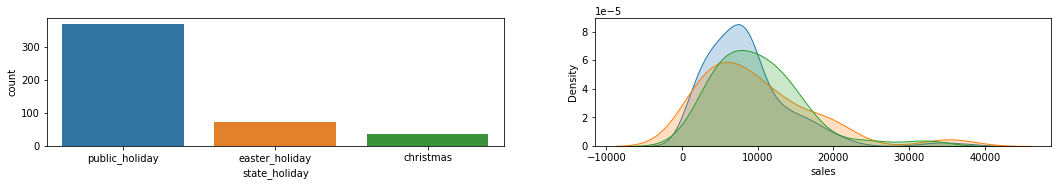

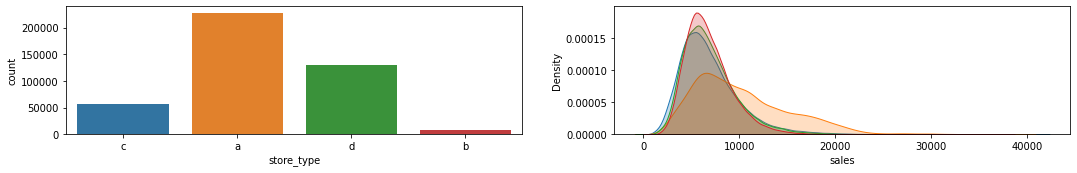

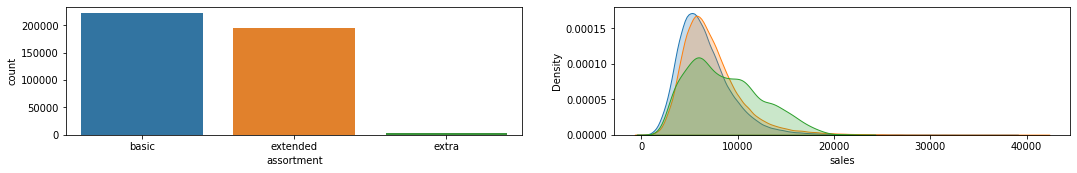

In [36]:
# state_holiday
df_holidays=df4[df4['state_holiday']!='regular_day']

plt.figure(figsize=(18, 8))
plt.subplot(3,2,1)
sns.countplot(x=df_holidays['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday',legend=True, shade=True);
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday',legend=True, shade=True);
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], label='christmas', legend=True, shade=True);

#plt.subplot(3,,3)
#sns.kdeplot(data=df_holidays, x='sales', hue='state_holiday', palette='crest', shade=True)

# store_type
plt.figure(figsize=(18, 8))
plt.subplot(3,2,3)
sns.countplot(x=df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], shade=True,label='a', legend=True);
sns.kdeplot(df4[df4['store_type']=='b']['sales'], shade=True,label='b', legend=True);
sns.kdeplot(df4[df4['store_type']=='c']['sales'], shade=True,label='c', legend=True);
sns.kdeplot(df4[df4['store_type']=='d']['sales'], shade=True,label='d', legend=True);


# assortment
plt.figure(figsize=(18, 8))
plt.subplot(3,2,5)
sns.countplot(x=df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], shade=True, label='basic');
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], shade=True,label='extended');
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], shade=True, label='extra');

## 4.2. Análise Bivariada

### <b>H1.</b>Lojas com maior diversidade de produtos deveriam vender mais;
<b>FALSE.</b> O assortemt do type 'extra' é na realidade o que vende menos. Existe ma teoria no campo das vendas que diz que a quantidade de produos expostos ao mesmo tempo na realidade confunde o cliente, não o deixa confiante na compra.


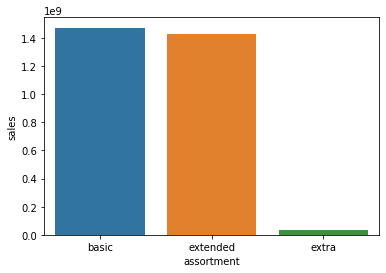

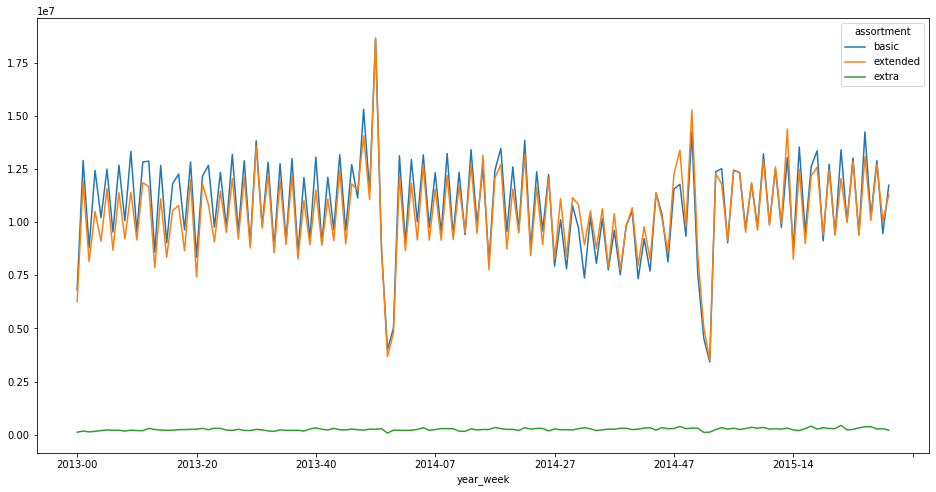

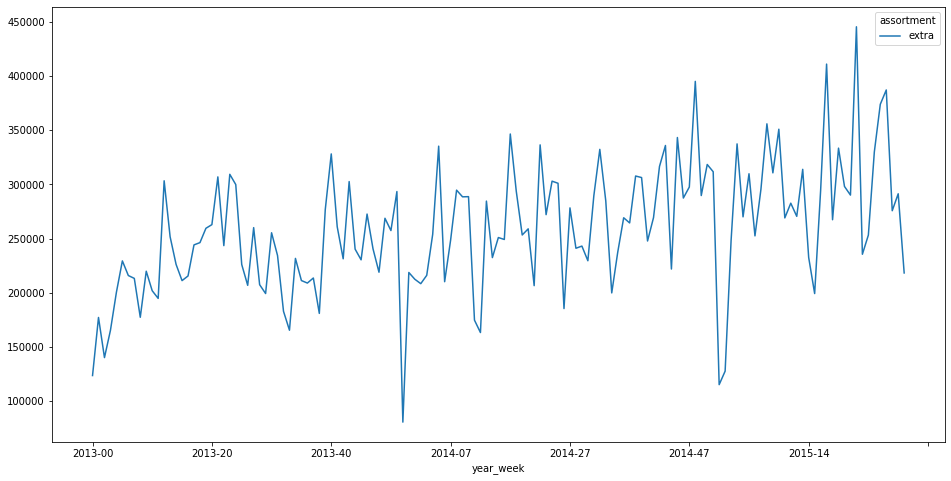

In [37]:
H1=df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment', y='sales', data=H1);
# Para desvendar se essa variável tem uma tendência de tempo pode-se verificar qual se há alteração siginificativa 
#de acordo com o tempo

aux1 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index();

aux1.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(16,8));

#Devido à escala do extra ser bem menor que as demais então olhar com maiores detalhes para essa linha é uma opção
aux2=aux1[aux1['assortment']=='extra']

aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(16,8));

### <b>H2.</b>Lojas com competidores mais próximos deveriam vender menos;
<b>FALSE.</b> Lojas com competidores mais próximos vendem mais, com excessão das lojas que não tinha competidores plotados nos gráficos anteriores, o scatterplot deixa esse número em evidência.

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

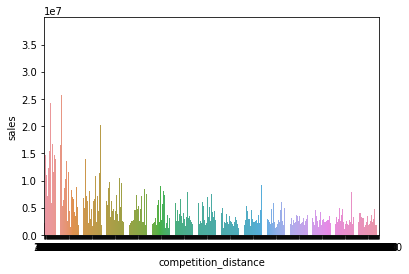

In [38]:
H2=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
sns.barplot(x='competition_distance', y='sales', data=H2)

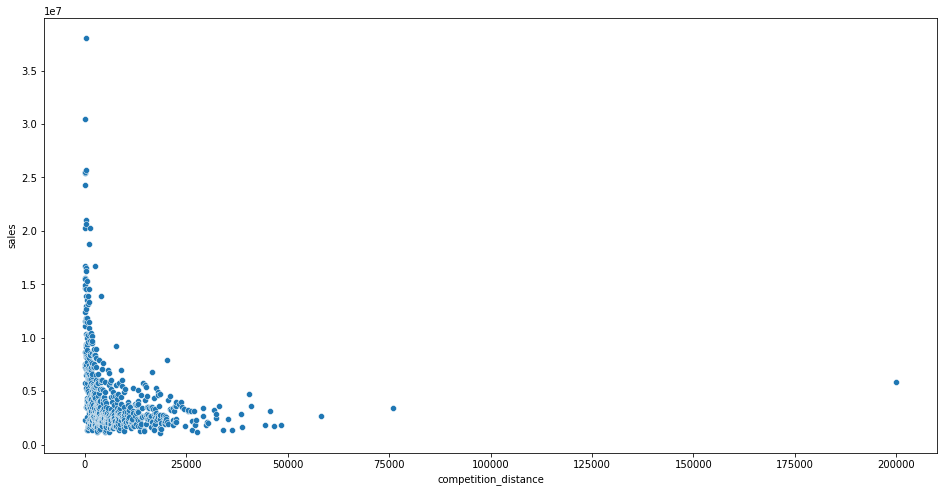

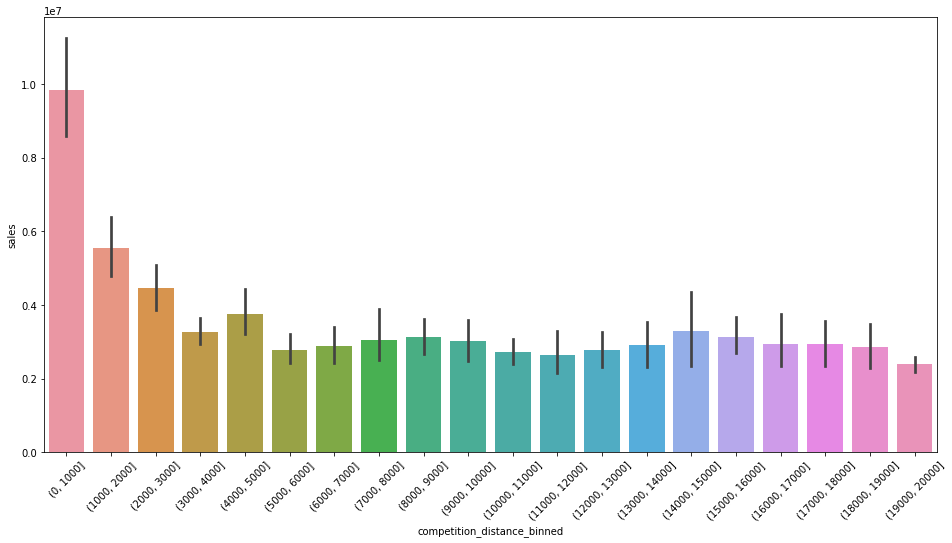

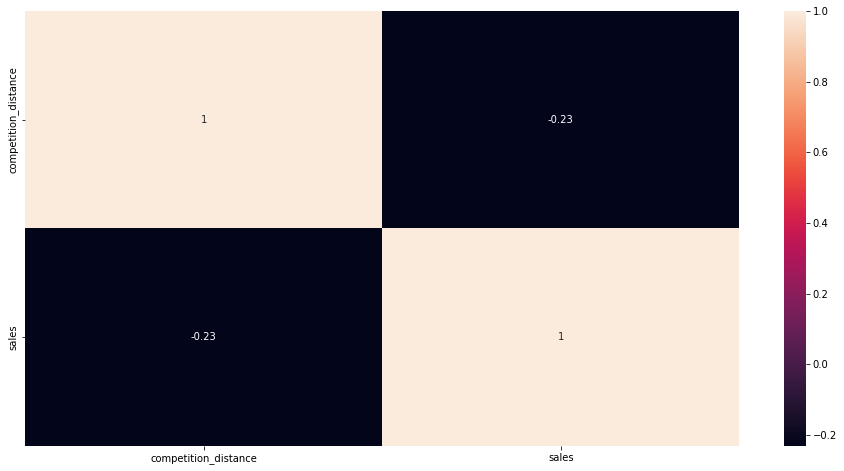

In [39]:
#Para validar melhor essa hipôtese é melhor criar grupos, vamos diminuir a granularidade dos dados junando em grupos de 1000 em 1000 metros de distância;
plt.figure(figsize=(16,8))
sns.scatterplot(x='competition_distance', y='sales', data=H2)

bins=list(np.arange(0,20001, 1000))
H2['competition_distance_binned']=pd.cut(H2['competition_distance'], bins=bins)
plt.figure(figsize=(16,8));
plt.xticks(rotation=45);
sns.barplot(x='competition_distance_binned', y='sales', data=H2);

#Olhando as correlações:
plt.figure(figsize=(16,8))
sns.heatmap(H2.corr(method='pearson'), annot=True);

#Existia um bug para ver as variáveis no meio, então caso ocorra novamente podemos realizar a seguinte prática:
# x = sns.hetmap(H2.corr(method='pearson'), annot=True);
# bottom, top = x.get_ylim()
# x.set_ylim(bottom+0.5, top-0.5);

### <b>H3.</b>Lojas com competidores de longa data deveriam vender mais;
<b>FALSE</b> Lojas com competidores que se consolidam vendem menos

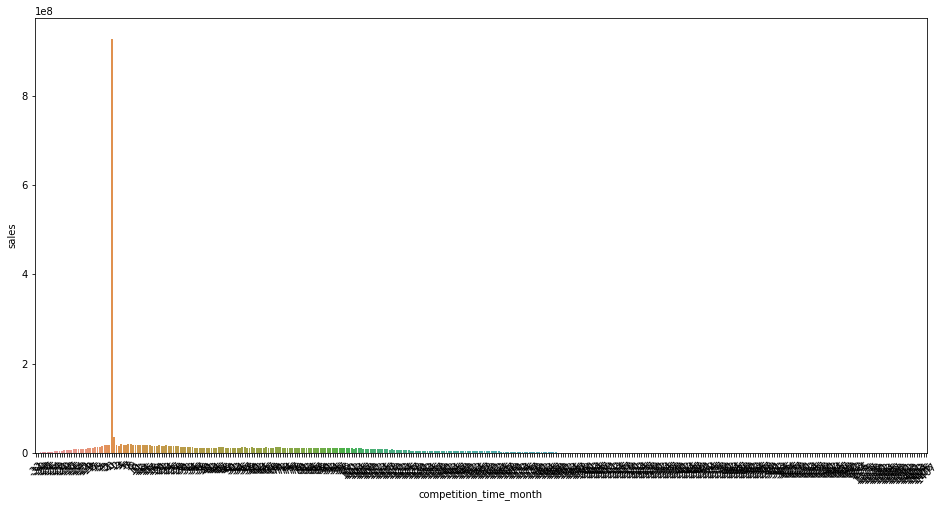

In [40]:
H3 =df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index();
plt.figure(figsize=(16,8))
sns.barplot(x='competition_time_month',y='sales', data=H3);
plt.xticks(rotation=45);

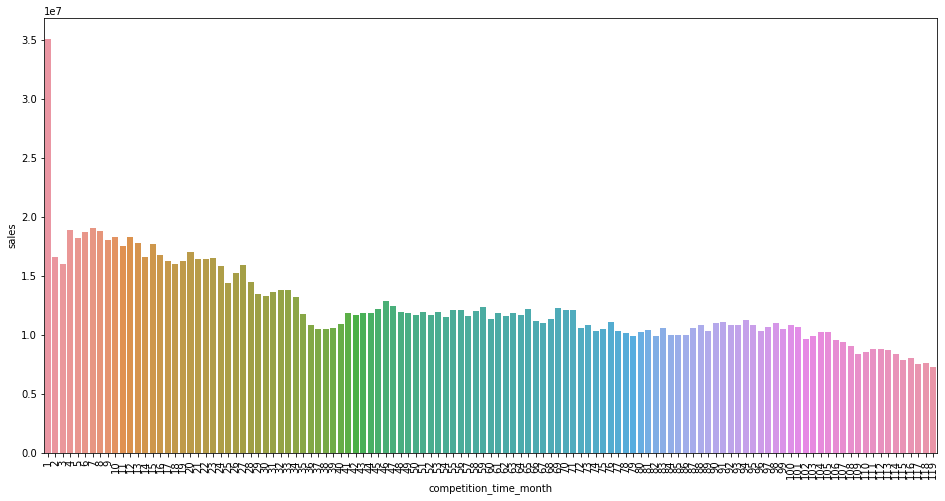

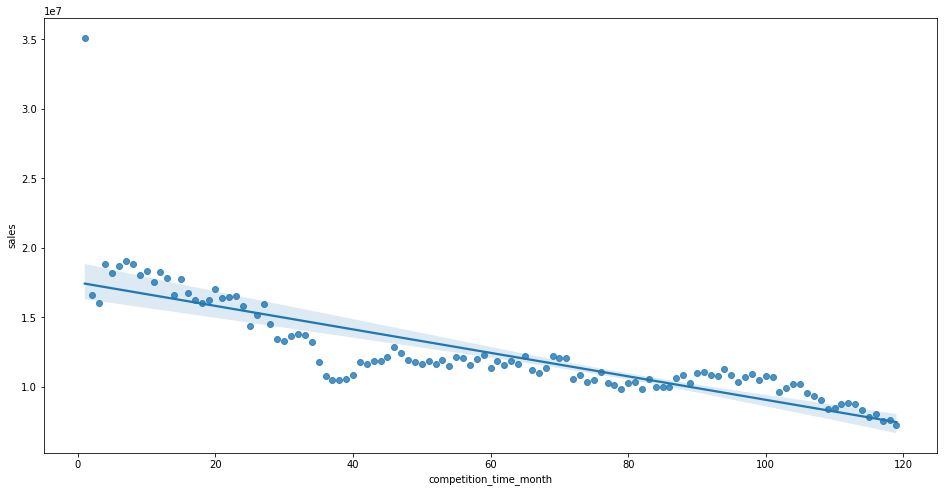

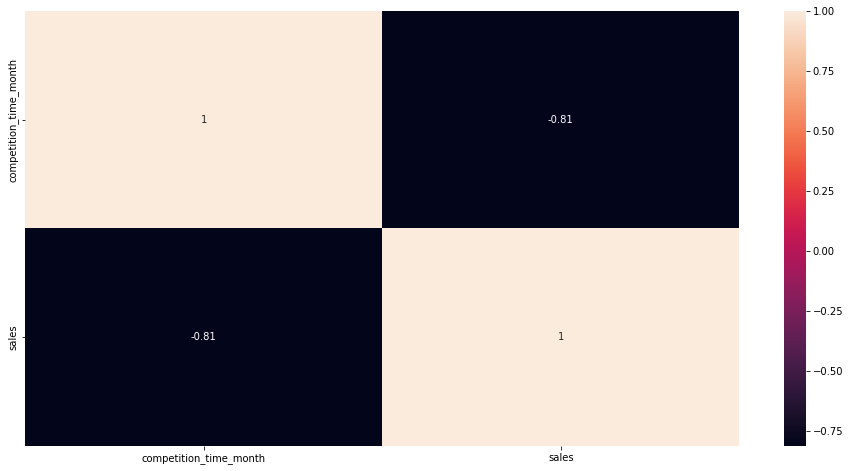

In [41]:
#Como temos uma resposta muito granular, assim como o gráfico passado devemos diminuir a granularidade ou filtrar as informações
#vê-se que a quantidade de informações tem váriáveis negativas, devido ao funcionamento dessa variável que foi derivada. 
#por isso, podemos retirar esses valores negativos das nossa informações

plt.figure(figsize=(16,8))
aux1=H3[(H3['competition_time_month']>0) & (H3['competition_time_month']<120)]
sns.barplot(x='competition_time_month',y='sales', data=aux1);
plt.xticks(rotation=90)


#Outro meios de verificar tendência, mas tendências lineares é:
plt.figure(figsize=(16,8))
sns.regplot(x='competition_time_month',y='sales',data=aux1);

#E o jeito tradicional é:
plt.figure(figsize=(16,8))
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <b>H4.</b>Lojas com promoções à mais tempo deveriam vender mais;
<b>FALSE.</b>Lojas com promoções à mais tempo vendem menos, pode ser devido ao fato de os clientes se acostumarem as promoções.

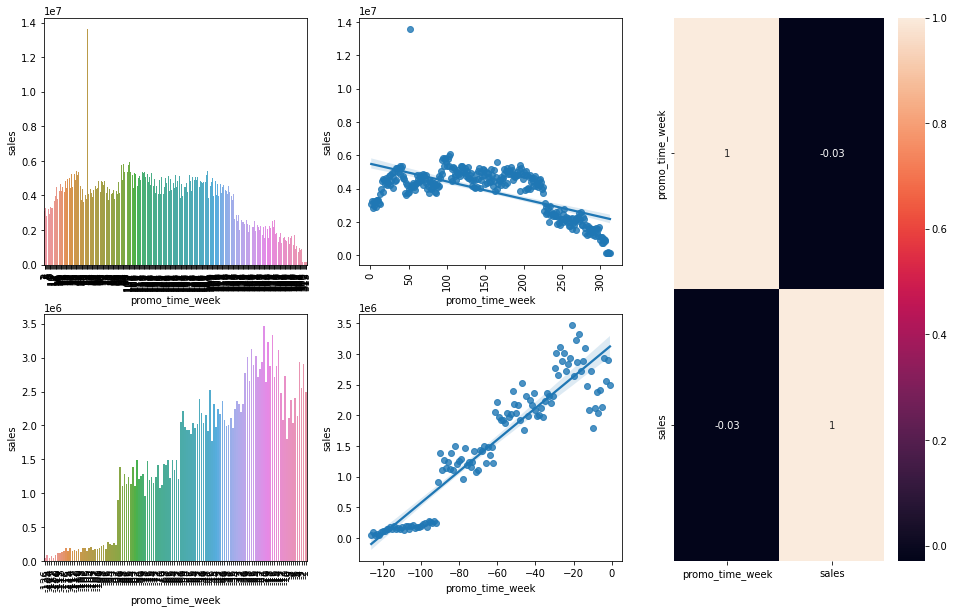

In [42]:
H4 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
aux1_h4 = H4[H4['promo_time_week']>0] #Promoção extendida
plt.figure(figsize=(16,10))

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux1_h4);
plt.xticks(rotation=90);


plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux1_h4);
plt.xticks(rotation=90);

aux2_h4 = H4[H4['promo_time_week']<0] #Promoção regular
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2_h4);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2_h4);

plt.subplot(grid[:,2])
sns.heatmap(H4.corr(method='pearson'), annot=True);

### <s><b>H5.</b>Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais</s>

### <b>H6.</b>Lojas com mais dias de promoção deveriam vender mais
<b>FALSE</b> Essa hipótese já foi validada anteriormente

### <b>H7.</b>Lojas com mais promoções consecutivas deveriam vender mais
<b>FALSE.</b> As lojas com a promoção extendidas na verdade venderam menos depois de um certo período

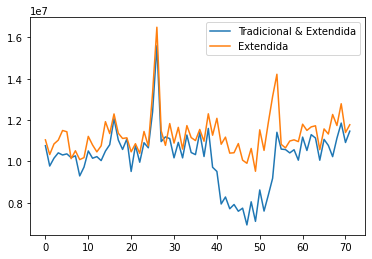

In [43]:
H7=df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

aux1_h7 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
h7_graf7 = aux1_h7.plot();

aux2_h7 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2_h7.plot(ax=h7_graf7);

h7_graf7.legend(labels=["Tradicional & Extendida", "Extendida"]);

### <b>H8.</b>Lojas abertas durante o feriado de natal deveriam vender mais
<b>FALSO</b> O Natal é o feriado com menor número de vendas.

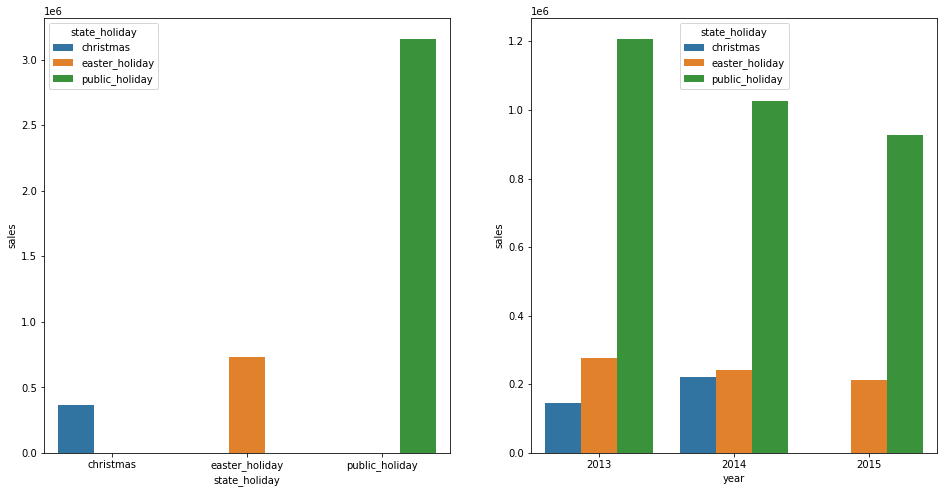

In [44]:
H8 = df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
H8 = H8[H8['state_holiday']!='regular_day']
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', hue='state_holiday', data=H8);

aux_h8 = df4[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
aux_h8 = aux_h8[aux_h8['state_holiday']!='regular_day']
plt.subplot(1,2,2);
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux_h8);

### <b>H9.</b>Lojas deveriam vender mais ao longo dos anos

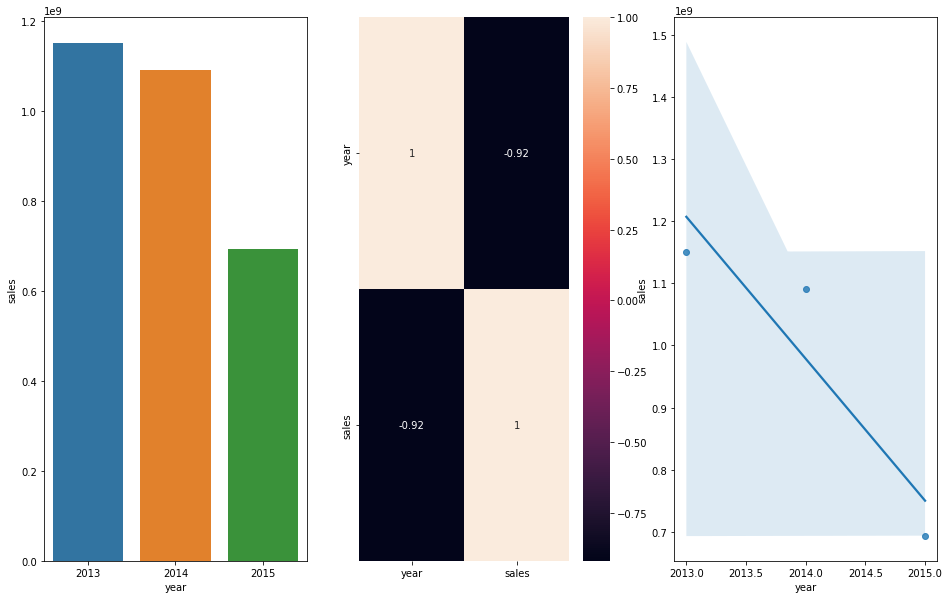

In [45]:
H9=df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(16,10))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=H9);
plt.subplot(1,3,2)
sns.heatmap(H9.corr(method='pearson'), annot=True);
plt.subplot(1,3,3)
sns.regplot(x='year', y='sales', data=H9);

### <b>H10.</b>Lojas deveriam vender mais no segundo semestre do ano

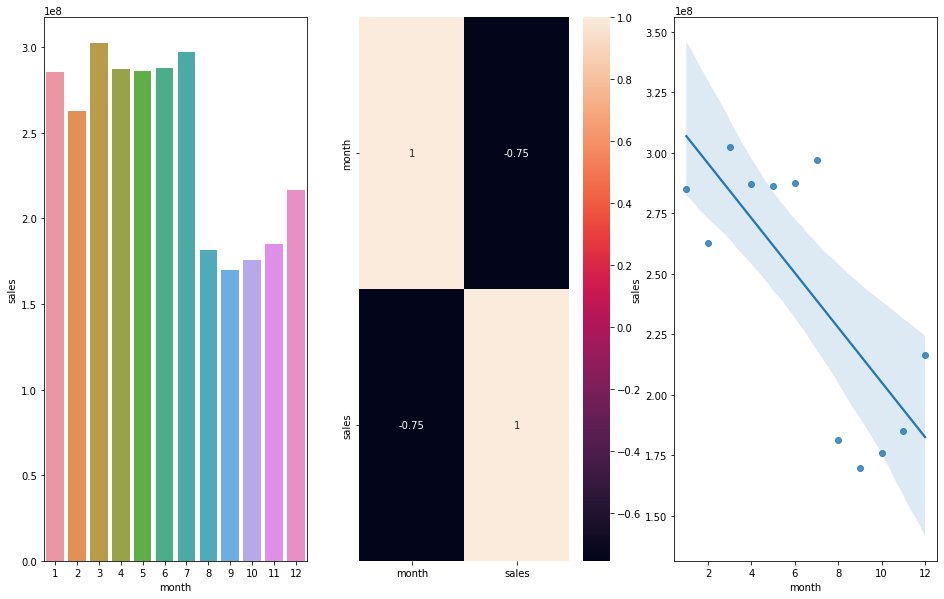

In [46]:
H10=df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(16,10))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=H10);
plt.subplot(1,3,2)
sns.heatmap(H10.corr(method='pearson'), annot=True);
plt.subplot(1,3,3)
sns.regplot(x='month', y='sales', data=H10);

### <b>H11.</b>Lojas deveriam vender mais depois do dia 10 de cada mês

In [47]:
H11 = df4[['day', 'sales']]
H11["before_or_after"] = df4['day'].apply(lambda x: 'before' if x<=10 else 'after')
H11

C:\Users\User\AppData\Local\Temp\ipykernel_14416\1545048511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H11["before_or_after"] = df4['day'].apply(lambda x: 'before' if x<=10 else 'after')


,day,sales,before_or_after
0,31,5263,after
3,31,13995,after
5,31,5651,after
8,31,8565,after
9,31,7185,after
...,...,...,...
1016776,1,3375,before
1016827,1,10765,before
1016863,1,5035,before
1017042,1,4491,before


### <b>H12.</b>Lojas deveriam vender menos aos finais de semana

<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

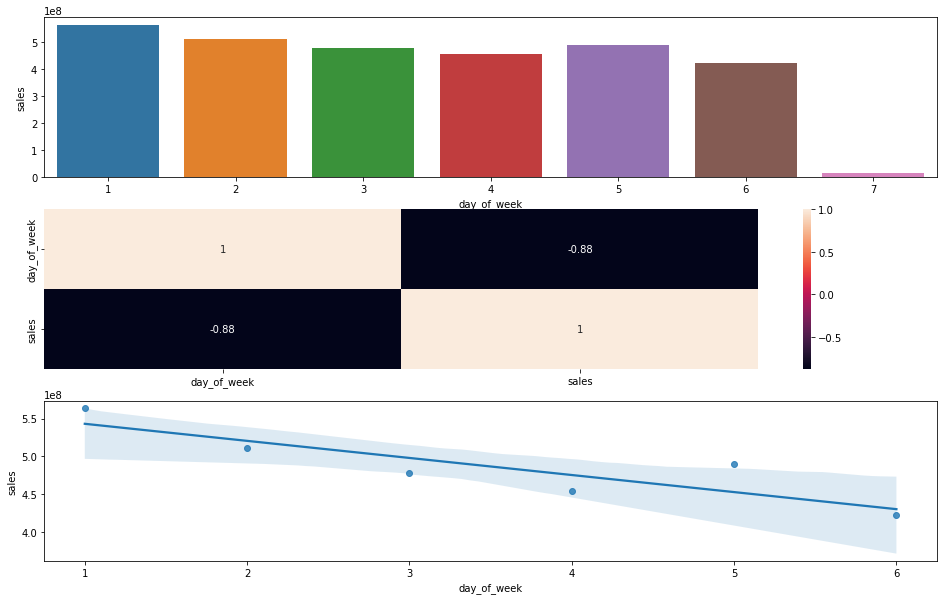

In [48]:
H12 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize=(16,10))

plt.subplot(3,1,1)
sns.barplot(x='day_of_week', y='sales', data=H12)

aux1=H12[H12['day_of_week']!=7]
plt.subplot(3,1,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(3,1,3)
sns.regplot(x='day_of_week', y='sales', data=aux1)

### <b>H13.</b>Lojas deveriam vender menos durante os feriados escolares

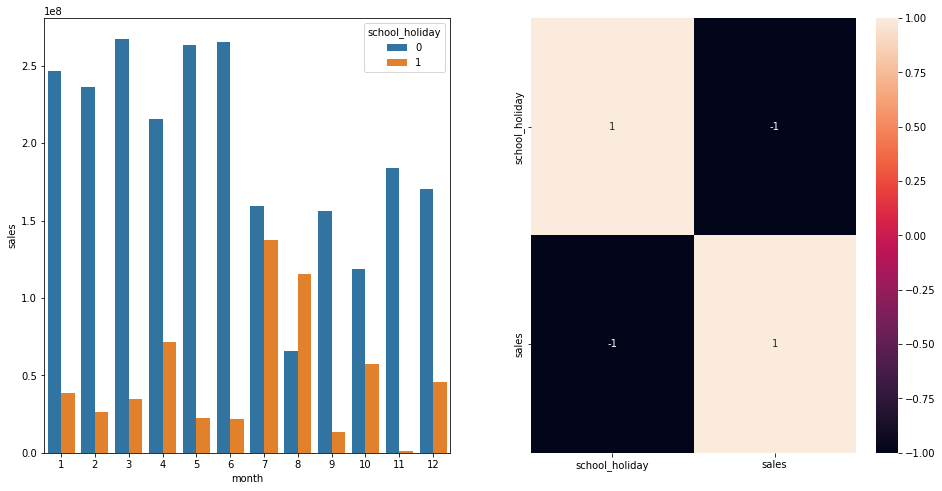

In [49]:
H13 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
aux2 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
sns.barplot(x='month', y='sales', hue='school_holiday', data=H13);

plt.subplot(1,2,2)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

## 4.3. Análise Multivariada

### 4.3.1. Análise Numérica

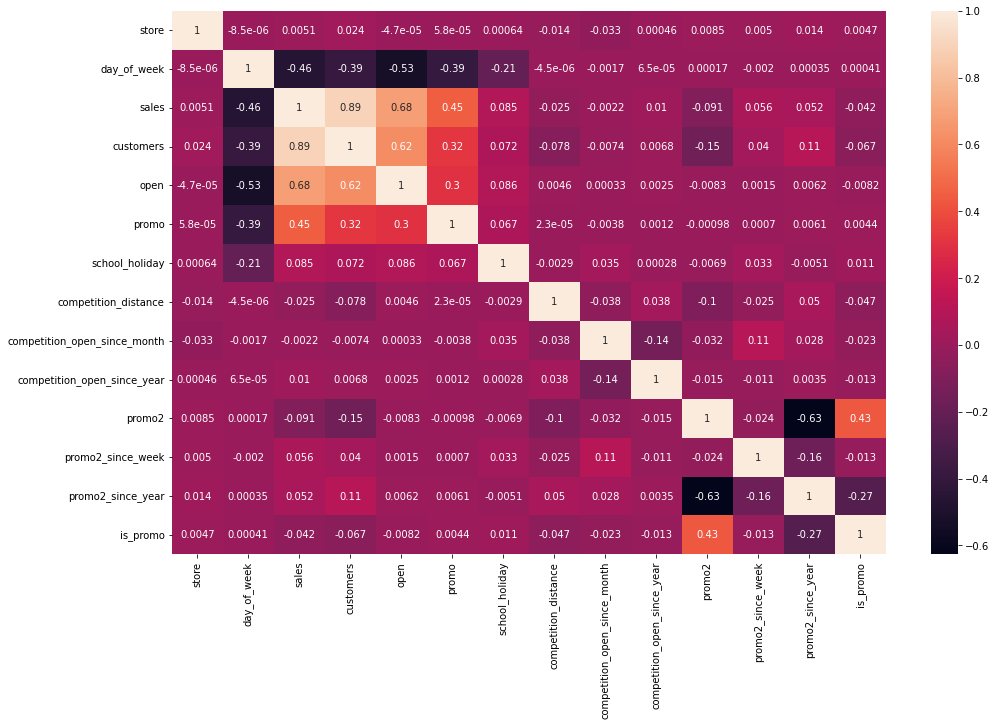

In [50]:
correlation = num_attributes.corr(method='pearson');
plt.figure(figsize=(16, 10))
sns.heatmap(correlation, annot=True);

### 4.3.2. Análise Categórica

<AxesSubplot:>

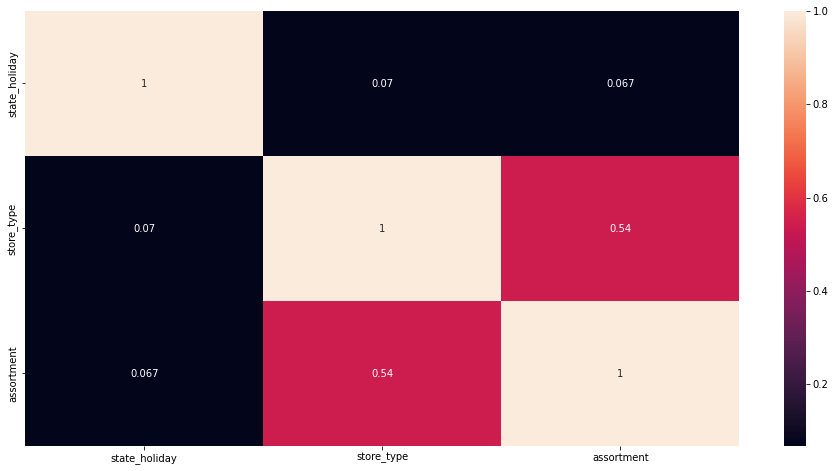

In [51]:
#cat_attributes is outdated so to update the information we can to creat a variable from df4

cat_attributes_updated = df4.select_dtypes(include="object")
cat_attributes_updated = cat_attributes_updated.drop('year_week', axis='columns')

# calculting crames'v:
a1 = cramer_v(cat_attributes_updated['state_holiday'], cat_attributes_updated['state_holiday'])
a2 = cramer_v(cat_attributes_updated['state_holiday'], cat_attributes_updated['store_type'])
a3 = cramer_v(cat_attributes_updated['state_holiday'], cat_attributes_updated['assortment'])

a4 = cramer_v(cat_attributes_updated['store_type'], cat_attributes_updated['state_holiday'])
a5 = cramer_v(cat_attributes_updated['store_type'], cat_attributes_updated['store_type'])
a6 = cramer_v(cat_attributes_updated['store_type'], cat_attributes_updated['assortment'])

a7 = cramer_v(cat_attributes_updated['assortment'], cat_attributes_updated['state_holiday'])
a8 = cramer_v(cat_attributes_updated['assortment'], cat_attributes_updated['store_type'])
a9 = cramer_v(cat_attributes_updated['assortment'], cat_attributes_updated['assortment'])

#Createing a dataframe with anwsers:
cramer_df = pd.DataFrame({'state_holiday':[a1,a2,a3],
                              'store_type':[a4,a5,a6],
                              'assortment':[a7,a8,a9]})
cramer_df.index=cramer_df.columns

# Heat map to do it more visual:
plt.figure(figsize=(16,8))
sns.heatmap(cramer_df, annot=True)

# 5.0. DATA PREPARATION

In [52]:
df5 = df4.copy()

## 5.1. Normalization

In [53]:
# It don't have any variable with normal distribution

## 5.2. Rescaling

In [54]:
a = df5.select_dtypes(include=['float64', 'int64'])

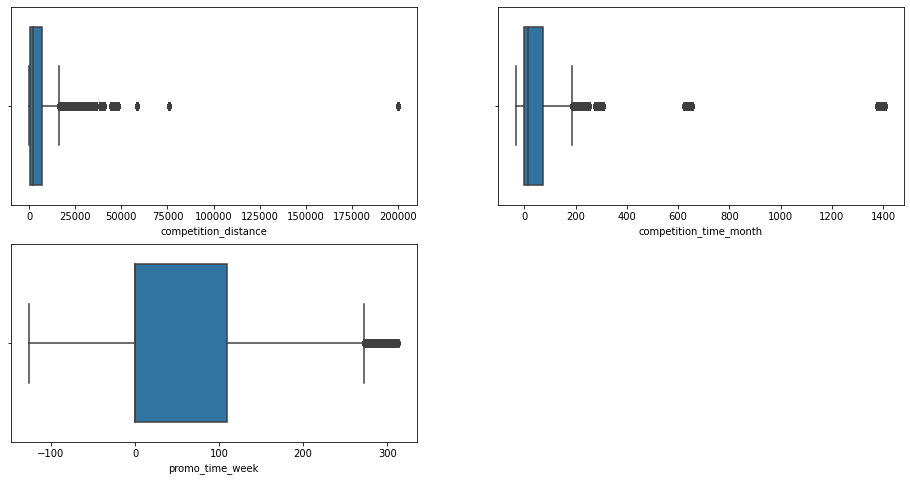

In [55]:
grid = GridSpec(2, 2)

plt.figure(figsize=(16,8))
plt.subplot(grid[0,0])
sns.boxplot(x='competition_distance', data=a);
plt.subplot(grid[0,1])
sns.boxplot(x='competition_time_month', data=a);
plt.subplot(grid[1,0])
sns.boxplot(x='promo_time_week', data=a);

In [145]:
rs =RobustScaler()
mms=MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter//competition_distance_scaler.pkl', 'wb'))
# competition time month
df5['competition_time_month'] = mms.fit_transform(df5[['competition_time_month']].values)
pickle.dump(mms, open('parameter//competition_time_month_scaler.pkl', 'wb'))
# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter//promo_time_week_scaler.pkl', 'wb'))
# year 
df5['year']=mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter//year_scaler.pkl', 'wb'))

## 5.3. Transformation

### 5.3.1. Enconding

In [57]:
#state_holiday
df5=pd.get_dummies(df5,prefix=['state_hoiliday'], columns=['state_holiday'])

#store_type
le=LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter//store_type_scaler.pkl', 'wb'))

#assortment
assort_dict={'basic':1, 'extra':2, 'extended':3}
df5['assortment']=df5['assortment'].map(assort_dict)

### 5.3.2. Response Variable Transformation

In [58]:
df5['sales'] = np.log1p(df5['sales'])

<Figure size 1152x576 with 0 Axes>

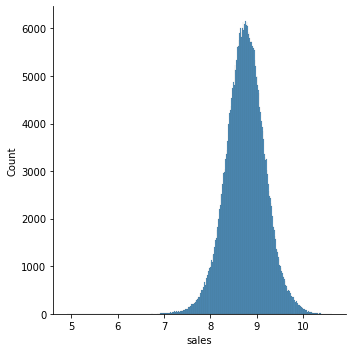

In [59]:
plt.figure(figsize=(16,8))
sns.displot(df5['sales']);

In [60]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*(np.pi/7))))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*(np.pi/7))))
                                            
# month
df5['month_sin']=df5['month'].apply(lambda x: np.sin(x*(2.*(np.pi/12))))
df5['month_cos']=df5['month'].apply(lambda x: np.cos(x*(2.*(np.pi/12))))

# day
df5['day_sin']=df5['day'].apply(lambda x: np.sin(x*(2.*(np.pi/30))))
df5['day_cos']=df5['day'].apply(lambda x: np.cos(x*(2.*(np.pi/30))) )                              

# week of year
df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x: np.sin(x*(2.*(np.pi/52))))
df5['week_of_year_cos']=df5['week_of_year'].apply(lambda x: np.cos(x*(2.*(np.pi/52))))


In [61]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'state_hoiliday_christmas', 'state_hoiliday_easter_holiday',
       'state_hoiliday_public_holiday', 'state_hoiliday_regular_day',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos'],
      dtype='object')

# 6.0. FEATURE SELECTION

In [62]:
df6 = df5.copy()

## 6.1.Split dataframe into training and test dataseti

In [63]:
cols_drop=['week_of_year', 'day', 'year_week', 'month', 'day_of_week', 'promo_since', 'competition_since']
df6=df6.drop(cols_drop, axis=1)
# As vendas deverão ser agrupadas por data, já que tratasse se uma análise preditiva. Logo para trainar o modelo podemos pegar as 
# vendas passadas e avaliar os valores.

In [64]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - (datetime.timedelta(days=7*6))

Timestamp('2015-06-19 00:00:00')

In [65]:
#train dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#Test dataset
X_test = df6[df6['date']>='2015-06-19']
Y_test = X_test['sales']

print("Valor mínimo da data de treino: {}".format(X_train['date'].min()))
print("Valor máximo da data de treino: {}".format(X_train['date'].max()))

print("\nValor mínimo da data de test: {}".format(X_test['date'].min()))
print("Valor máximo da data de test: {}".format(X_test['date'].max()))

Valor mínimo da data de treino: 2013-01-01 00:00:00
Valor máximo da data de treino: 2015-06-18 00:00:00

Valor mínimo da data de test: 2015-06-19 00:00:00
Valor máximo da data de test: 2015-07-31 00:00:00


## 6.2. Boruta as feauture selector

In [66]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. MACHINE LEARNING MODELLING

In [67]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [68]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1,aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance

baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1336.274598,0.204487,1821.450063


## 7.2. Linear Regression

In [69]:
#model
lr = LinearRegression().fit(x_train, Y_train)

#predition
yhat_lr = lr.predict(x_test)

#performance
lr_result =ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1865.263255,0.294964,2674.711629


### 7.2.1. Linear Regression - Cross Validation

In [73]:
### 7.2.1. Linea Regression Model - Cross Validation
lr_result_cv = cross_validation( 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2083.99 +/- 290.35,0.30 +/- 0.02,2952.43 +/- 460.84


## 7.3. Linear Regression Regularized Model - Lasso

In [74]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

#predition
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1887.634938,0.291006,2744.76932


### 7.3.1. Lasso- Cross Validation

In [75]:
### 7.2.1. Linea Regression Model - Cross Validation
lrr_result_cv = cross_validation( 5,'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2119.47 +/- 338.21,0.29 +/- 0.01,3061.95 +/- 499.50


## 7.4.Random Forest Regressor

In [76]:
#model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train, Y_train)

#predition
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regression', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regression,695.266675,0.102271,1045.928556


### 7.4.1. Random Forest - Cross Validation

In [ ]:
### 7.2.1. Linea Regression Model - Cross Validation
rf_result_cv = cross_validation(5, 'Randon Forest', rf, verbose = False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Randon Forest,897.59 +/- 286.86,0.12 +/- 0.03,1344.68 +/- 429.26


## 7.5.XGBoost Regressor

In [77]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytree=0.9).fit(x_train, Y_train)

#predition
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6663.415934,0.949145,7310.915906


### 7.2.1. Linear Regression - Cross Validation

In [78]:
### 7.2.1. Linea Regression Model - Cross Validation
xgb_result_cv = cross_validation(5 , 'XGBoost', model_xgb, verbose = False) 
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,7049.58 +/- 582.62,0.95 +/- 0.00,7718.24 +/- 682.74


## 7.6. Compare Model's Performace

### 7.6.1 Single Performace

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regression,695.266675,0.102271,1045.928556
0,Average Model,1336.274598,0.204487,1821.450063
0,Linear Regression,1865.263255,0.294964,2674.711629
0,Linear Regression - Lasso,1887.634938,0.291006,2744.769320
0,XGBoost Regressor,1887.634938,0.291006,2744.769320


### 7.6.2. Real Performace

In [ ]:

modelling_result = pd.concat([ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2083.99 +/- 290.35,0.30 +/- 0.02,2952.43 +/- 460.84
0,Lasso,2119.47 +/- 338.21,0.29 +/- 0.01,3061.95 +/- 499.50
0,Randon Forest,897.59 +/- 286.86,0.12 +/- 0.03,1344.68 +/- 429.26
0,XGBoost,7049.58 +/- 582.62,0.95 +/- 0.00,7718.24 +/- 682.74


Agora comparando os erros podemos ver que o RMSE da Random Florest foi o menor, o que poderia ser um grande indicativo da
eficância do modelo, entretanto como separamos o modelo para treino e teste de maneira muito simples, pode ter ocorrido
casos adversos ao cenário real, por isso vamos aplicar a técnica de cross-valisation, que permite tirar fatias mais reais do 
cenario exposto com os dados

# Performace real dos modelos
Se a gente pega só um perído dos dados em uma time series a gente corre o risco de pegar a melhor ou pior semana de vendas, por
isso é importante adicionar aleatóriedade à essa separação. Por isso vamos dividir o conjunto de dados em várias partes para medir
a performace do modelo sobre cada uma dessas partes tratasse da cross validation.
O cross-validation pode ser usado de uma maneira no caso de casos de regressão e classificação e existe outra forma de utilizar essa
técnica quando estamos trabalhando com times series.

A cross validtion funciona pegando os dados de treino já separados e fazendo uma nova separação em treino e validaação, onde os
dados de validação são usados como resultados e os erros calculados a partir deles. Isso é feito consecutivas vezes para que se 
tenha uma boa amostragem.

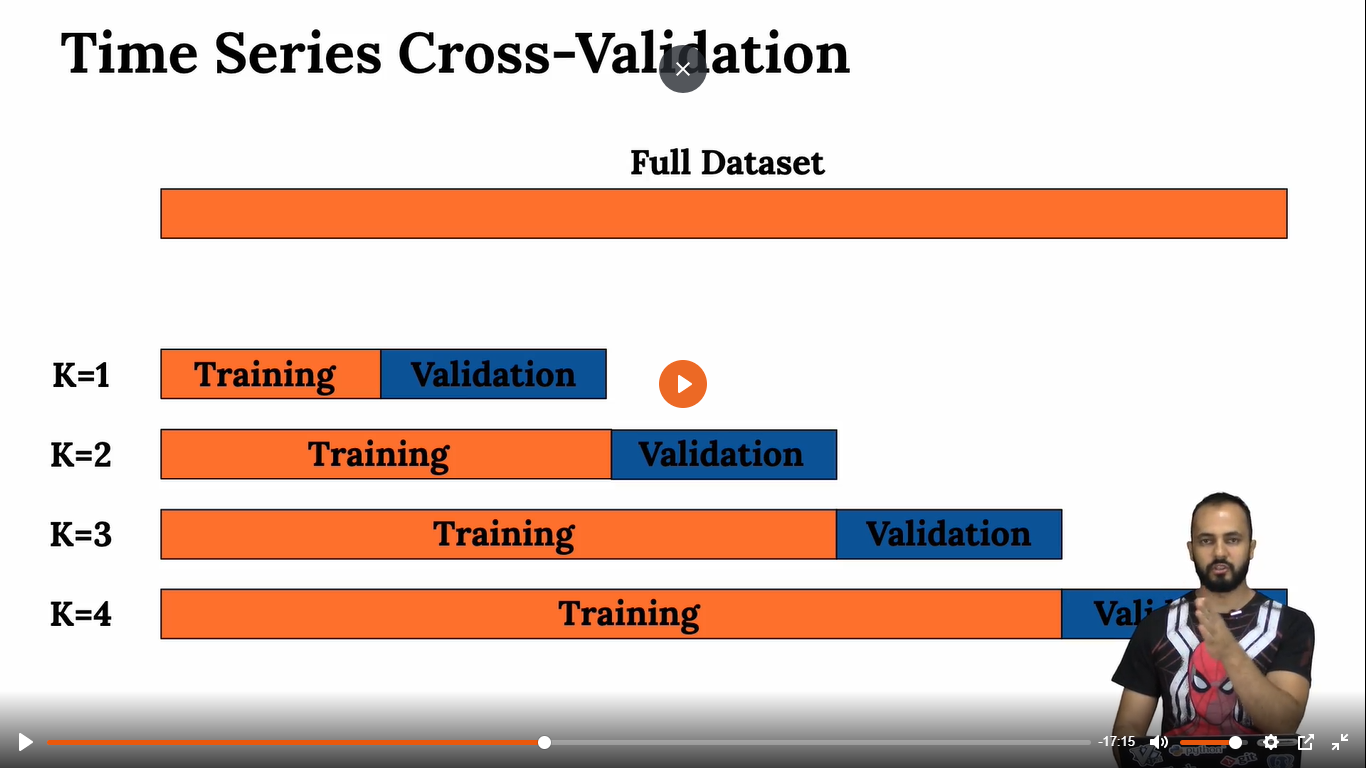

Na aula 30 implementamos uma função relacionada para fazer o cross validation, inicialmente nos vamos fazer as separações pelas datas, com validação e treinamento por meio de um looping que consegue split as datas com os dados variando em periodos - para isso utlizamos uma deltatime. é nesse momento também que lembramos que o treino não pode ter a resposta, por isso em sequeEncia eu faço um drop das solunas de 'date' e 'sales'.
Após fazer esse looping podemos colocar em ordem e fazer uma médias dos valores de erro (mae, mape, rmse) agregados à lista em cada passagem do looping.
Para finalizar podemos fazer uma representação, por meio de DataFrame dos erros +/- o desvio padrão de cada um deles.

# 8.0. Fine Tunnning

Agora vamos melhorar os parametros que estão setados, por meio do fine tunning.
Três estratégias diferentes:
1. Randon Search: definindo os valores dos hiperparâmetros aleatóriamente;
    Para esse tipo de fine tuning you can choose de parametres in a range possible, so we trie e choose the better result.
    Advantages: Rápido e baixo custo
    Desvatagens: Não utiliza aprendizado então faz tudo com valores aletórios. 

2. Grid Search: Combina todos os valores possiveis para encontrar os melhores parâmetros;
    Monta combinações entre todos os possíveis valores de todos os parâmetros;
    Vantagens: Ele realmente vai encontrar o conjunto de valores para cada hiperparametro que maximizam o modelo;
    Desvantagem: Leva muito tempo e em um servidor isso pode gerar custos e muito tempo;
    OBS: esse tipo de ajuste leva muito tempo e não dá um salto gigante na performace, então ele deve ser só o ajuste fino no projeto.
    a. Vantagens: Define os verdadeitos valores que mazimam o aprendizado do modelo.
    b. Desvantagens: Muito demorado mesmo e alto custo.

3. Bayesian Search: Segue a teoria de Bayes para conseguir os mlehores valores para os hiperparâmetros.
    P(A|B) =  (P(B|A)* P(A))/ P(B)
    a. Vantagens: Define os valorees para os hiperparâmetros baseados em aprendizados passados;
    b. Desvantages: Mais rápiodo que o Grid Search e mais lento que o Random Search.
    


## 8.1. Random Search

param = {
    'n_estimators':[1500, 2500, 3000, 3500],
    'eta':[0.01, 0.03, 0.05],
    'max_depth':[3 , 5, 9],
    'subsample':[0.1, 0.5, 0.7],
    'colsample_bytree':[0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    #choose values for parameters randomly
    hp = { k: random.sample(v,1)[0] for k, v in param.items()}
    print (hp)

    #model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=hp['n_estimators'],
    eta=hp['eta'],
    max_depth=hp['max_depth'],
    subsample=hp['subsample'],
    colsample_bytree= hp['colsample_bytree'],
    min_child_weight=hp['min_child_weight'])

    #performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, True)
    final_result = pd.concat([final_result, result])

final_result

In [79]:
param_tuned = {
    'n_estimators':3000,
    'eta':0.03,
    'max_depth':5,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3
}

In [92]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
n_estimators=param_tuned['n_estimators'],
eta=param_tuned['eta'],
max_depth=param_tuned['max_depth'],
subsample=param_tuned['subsample'],
colsample_bytree=param_tuned['colsample_bytree'],
min_child_weight=param_tuned['min_child_weight']).fit(x_train, Y_train)

#predition
yhat_xgb_tuned= model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,765.918813,0.115463,1112.559008


# 9.0.TRADUÇÃO E INTERPRETAÇÃO DO ERRO

Os o modelos de regressão têm medidas de erro diferente dos demais, então é sim importante olhar para cada erro. 

In [96]:
df9=X_test[cols_selected_boruta_full]

In [97]:
# rescale (varivel response)
df9['sales'] = np.expm1(df9['sales'])
df9['predictions']= np.expm1(yhat_xgb_tuned)

C:\Users\User\AppData\Local\Temp\ipykernel_14416\3152162848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\User\AppData\Local\Temp\ipykernel_14416\3152162848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions']= np.expm1(yhat_xgb_tuned)


## 9.1. Business Performance

In [120]:
# sum of prediction
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE:
df9_aux1=df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2=df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x:100*( mean_absolute_percentage_error(x['sales'], x['predictions']))).reset_index().rename(columns={0:'MAPE(%)'})

#Merge MAE and MAPE
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Translate to bussiness (Scenarys)
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns
df92=df92[['store','predictions','best scenary', 'worst scenary', 'MAE', 'MAPE(%)']]

## 9.2. Total Perfomance

In [121]:
df92.sort_values('MAPE(%)', ascending=False).head()

,store,predictions,best scenary,worst scenary,MAE,MAPE(%)
908,909,88315.289062,98449.651150,78180.926975,10134.362088,79.073071
875,876,100993.835938,105321.831991,96665.839884,4327.996053,42.294410
482,483,82064.242188,83038.301313,81090.183062,974.059125,34.921057
169,170,109285.101562,110644.729895,107925.473230,1359.628333,34.103150
291,292,34532.792969,38765.334391,30300.251546,4232.541423,31.205472


<AxesSubplot:xlabel='store', ylabel='MAPE(%)'>

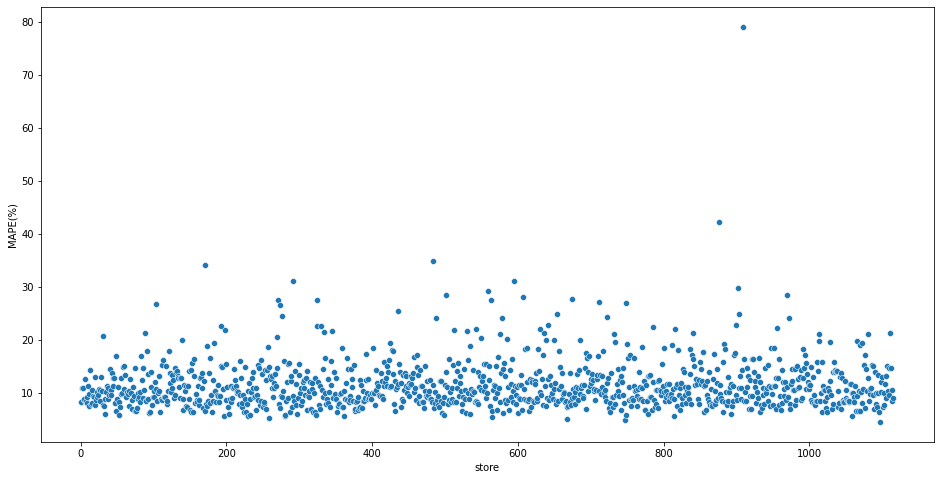

In [141]:
plt.figure(figsize=(16,8))
sns.scatterplot(x='store', y='MAPE(%)', data=df92)

In [123]:
df93=df92[['predictions', 'worst scenary', 'best scenary']].apply(lambda x: np.sum(x), axis=0).reset_index().rename( columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$142,160,992.00"
1,worst scenary,"R$141,299,234.43"
2,best scenary,"R$143,022,743.60"


## 9.3.Machine Learning Performance

In [125]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

C:\Users\User\AppData\Local\Temp\ipykernel_14416\1713337479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\User\AppData\Local\Temp\ipykernel_14416\1713337479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions']/df9['sales']


c:\Users\User\OneDrive\workspace\repositories\ds-em-producao\ds-em-producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\User\OneDrive\workspace\repositories\ds-em-producao\ds-em-producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


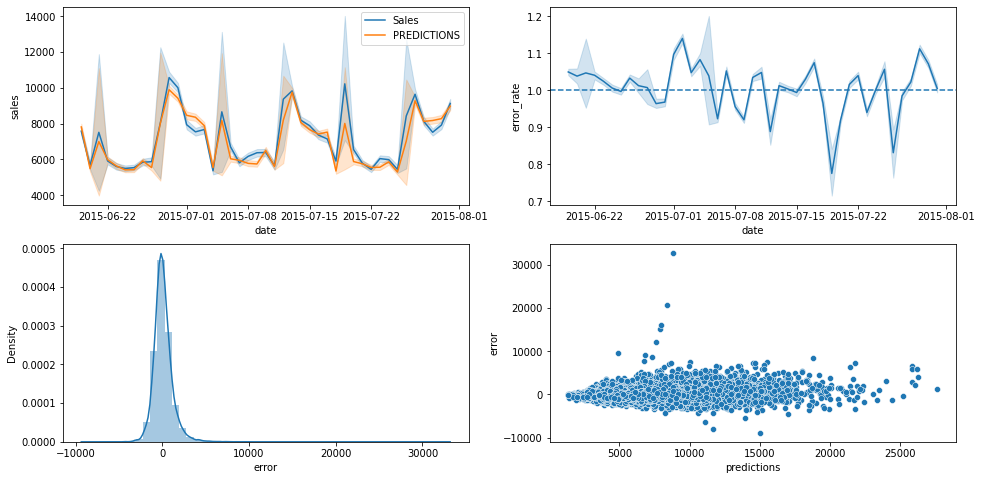

In [142]:
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='Sales')
sns.lineplot(x='date', y='predictions', data=df9, label= 'PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error']);

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10. DEPLOY OF MODEL TO PRODUCTION

In [ ]:
pickle.dump(model_xgb_tuned, open('C:\\Users\\User\\OneDrive\\workspace\\repositories\\ds-em-producao\\model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [ ]:
class Rossmann(object):
       def __init__(self):
              self.home_path = 'C:\\Users\\User\\OneDrive\\workspace\\repositories\\ds-em-producao\\'
              self.competition_distance_scaler   = pickle.load(open(self.home_path+'parameter//competition_distance_scaler.pkl', 'rb'))
              self.competition_time_month_scaler = pickle.load(open(self.home_path+'parameter//competition_time_month_scaler.pkl', 'rb'))
              self.promo_time_week_scaler        = pickle.load(open(self.home_path+'parameter//promo_time_week_scaler.pkl', 'rb'))
              self.year_scaler                   = pickle.load(open(self.home_path+'parameter//year_scaler.pkl', 'rb'))
              self.store_type_scaler             = pickle.load(open(self.home_path+'parameter//store_type_scaler.pkl', 'rb'))
              
       def data_cleaning(self, df1):
              cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                     'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
              snakecase = lambda x: inflection.underscore(x)
              cols_new = list(map(snakecase, cols_old))

              #rename
              df1.columns = cols_new

              ## 1.3. Data Types
              df1['date'] = pd.to_datetime(df1['date'])
              
              ## 1.5 Fillout NA
              #competition_distance
              df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

              #competition_open_since_month
              df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

              #competition_open_since_year     
              df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

              #promo2_since_week
              df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
                            
              #promo2_since_year
              df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
              
              #promo_interval
              month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'May', 5: 'Apr', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
              df1['promo_interval'].fillna(0, inplace=True)
              df1['month_map'] = df1['date'].dt.month.map(month_map)
              df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in str(x['promo_interval']).split(',') else 0, axis =1)

              ## 1.6 Change types
              df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
              df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
              df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
              df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

              return df1
       
       def feature_engineering(self, df2):       
              #year
              df2['year']= df2['date'].dt.year
              #month
              df2['month']= df2['date'].dt.month
              #day
              df2['day']= df2['date'].dt.day
              #week of year
              df2['week_of_year']= df2['date'].dt.isocalendar().week
              df2['week_of_year']= df2['week_of_year'].astype('int64')
              #year week
              df2['year_week']= df2['date'].dt.strftime('%Y-%W')

              #competition since
              df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
              df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

              #promo since
              df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)
              df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
              df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

              #assortment
              df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

              #state holiday
              df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')
              
              #filtering
              df2=df2[(df2['open'] !=0)]
              ### 3.2. Seleção de Colunas

              cols_drop = ['open', 'promo_interval', 'month_map']
              df2 = df2.drop(cols_drop, axis =1)

              return df2

       def data_preparation(self, df5):
              
              ## 5.2. Rescaling
              # competition distance
              df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
              
              # competition time month
              df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
              
              # promo time week
              df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)
              
              # year 
              df5['year']=self.year_scaler.transform(df5[['year']].values)
       
              ## 5.3. Transformation
              ### 5.3.1. Enconding
              #state_holiday
              df5=pd.get_dummies(df5,prefix=['state_hoiliday'], columns=['state_holiday'])

              #store_type
              
              df5['store_type'] = self.store_type_scaler_st.fit_transform(df5['store_type'])

              #assortment
              assort_dict={'basic':1, 'extra':2, 'extended':3}
              df5['assortment']=df5['assortment'].map(assort_dict)

              # day of week
              df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*(np.pi/7))))
              df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*(np.pi/7))))
                                                        
              # month
              df5['month_sin']=df5['month'].apply(lambda x: np.sin(x*(2.*(np.pi/12))))
              df5['month_cos']=df5['month'].apply(lambda x: np.cos(x*(2.*(np.pi/12))))

              # day
              df5['day_sin']=df5['day'].apply(lambda x: np.sin(x*(2.*(np.pi/30))))
              df5['day_cos']=df5['day'].apply(lambda x: np.cos(x*(2.*(np.pi/30))) )                              

              # week of year
              df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x: np.sin(x*(2.*(np.pi/52))))
              df5['week_of_year_cos']=df5['week_of_year'].apply(lambda x: np.cos(x*(2.*(np.pi/52))))

              cols_selected = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']
              
              return df5[cols_selected]
       
       def get_prediction(self, model, original_data, test_data):
              #prediction
              pred = model.predict(test_data)

              # join pred into the original data
              original_data['prediction'] = np.expm1(pred)

              return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('C:\\Users\\User\\OneDrive\\workspace\\repositories\\ds-em-producao\\model\\model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)
@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])

        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        #Instatiate Rossmann class
        pipeline = Rossmann()

        # data cleaning 
        df1 = pipeline.data_cleaning(test_raw)

        # feauture engineering
        df2 = pipeline.feature_engineering(df1)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        return df_response

    else:
        return Reponse('{}', status=200, mimetype='application//json')

if __name__== '__main__':
    app.run('0.0.0.0')

## 10.3. API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv('C:\\Users\\User\\OneDrive\\workspace\\repositories\\ds-em-producao\\data\\test.csv')

# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'].isin ([20,23,22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

#convert DataFrame to json
data= json.dumps(df_test.to_dict(orient='records'))

# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Conten-type': 'application/json'}
data=data

r=request.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
for i in range(len(d2)):
    print('Store Number {} will sell R$ {:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'], d2.loc[i,'prediction']))